In [1]:
import pandas as pd
import numpy as np

In [2]:
adj_prediction=pd.read_pickle('/Users/chenxj00/Documents/长江证券/一直预期gitlab/adjusted_prediction.pkl')

close_price=pd.read_csv('/Users/chenxj00/Documents/长江证券/一直预期gitlab/数据/dfcf-收盘价.csv',encoding='gb18030',dtype={'SECURITYCODE':str})
market_captical=pd.read_csv('/Users/chenxj00/Documents/长江证券/一直预期gitlab/数据/dfcf-总市值.csv',encoding='gb18030',dtype={'SECURITYCODE':str})



In [3]:
close_price['TRADEDATE']=pd.to_datetime(close_price['TRADEDATE'])
def change_date(x):
    if x.month==1:
        x='01-01'
    elif x.month==5:
        x='05-01'
    elif x.month==9:
        x='09-01'
    elif x.month==11:
        x='11-01'
    return x
close_price['without_year_date']=close_price['TRADEDATE'].map(lambda x: change_date(x))
close_price['date']=pd.to_datetime(close_price['TRADEDATE'].map(lambda x: str(x.year))+'-'+close_price['without_year_date'])

close_price=close_price.sort_values(by=['SECURITYCODE','date'])[['CLOSE_PRICE','SECURITYCODE','date']]
close_price_after2015=close_price[close_price['date'].map(lambda x:x.year>2014)]
close_price_after2015=close_price_after2015.pivot(index='date',values='CLOSE_PRICE',columns='SECURITYCODE')
PCT_change=close_price_after2015.pct_change()

In [4]:
market_captical=pd.read_csv('/Users/chenxj00/Documents/长江证券/一直预期gitlab/数据/dfcf-总市值.csv',encoding='gb18030',dtype={'SECURITYCODE':str})
market_captical['TRADEDATE']=pd.to_datetime(market_captical['TRADEDATE'])
market_captical['without_year_date']=market_captical['TRADEDATE'].map(lambda x: change_date(x))
market_captical['date']=pd.to_datetime(market_captical['TRADEDATE'].map(lambda x: str(x.year))+'-'+market_captical['without_year_date'])
market_captical=market_captical[['ZSZ','SECURITYCODE','date']]
market_captical_after2015=market_captical[market_captical['date'].map(lambda x: x.year>2014)].pivot(index='date',columns='SECURITYCODE',values='ZSZ')

In [5]:
def if_zero(x):
    if x==0:
        x=np.nan
    else:
        x=x
    return x
PE_ratio=market_captical_after2015/(adj_prediction.applymap(lambda x: if_zero(x)))



In [6]:
PE_ratio.to_pickle('PE_ratio.pkl')
PCT_change.to_pickle('PCT_Change.pkl')

In [7]:
score_pivot=pd.read_pickle('PE_ratio.pkl')
ret=pd.read_pickle('PCT_Change.pkl')

In [8]:
ret=ret[ret.columns[[(i.startswith('0'))|(i.startswith('3'))|(i.startswith('6')) for i in ret.columns.tolist()]].tolist()]
score_pivot=score_pivot[score_pivot.columns[[(i.startswith('0'))|(i.startswith('3'))|(i.startswith('6')) for i in score_pivot.columns.tolist()]].tolist()]

/Users/chenxj00/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 20320 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/chenxj00/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 30340 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/chenxj00/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 26631 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/chenxj00/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 39064 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/chenxj00/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 20320 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/chenxj00/opt/anaconda3/lib/python3.7/site-pac

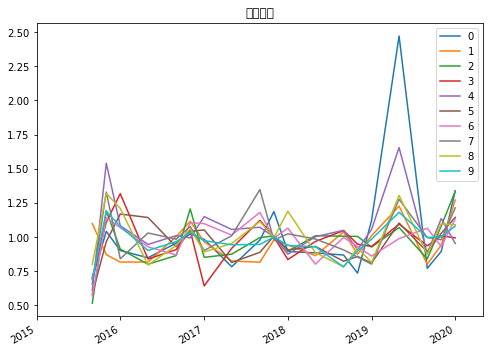

In [9]:
# 需要准备的两个数据
# score_pivot：处理好的因子值，数据类型为dataframe,index为日期，columns为股票代码，values为要测单调性的值
# ret：处理好的区间收益，数据类型为dataframe,index为日期（需要和score_pivot的index匹配），columns为股票代码，values为股票区间收益

df_quantile = pd.DataFrame()
n_groups = 10  # 回测单调性分成多少组

for i in range(n_groups):
    quantile_min=pd.Series()
    temp_min=list()
    for k in range(len(score_pivot.index.tolist())):
        index=score_pivot.index.tolist()[k]
        try:
            temp_value_min=np.percentile(np.array([j for j in score_pivot.loc[index].tolist() if not np.isnan(j)]),q=i*0.1)
            temp_min+=[temp_value_min]
        except:
            temp_min+=[np.nan]
    quantile_min = pd.Series(temp_min)
    quantile_min.index=score_pivot.index.tolist()  # 每组最小值
    quantile_pivot = pd.DataFrame(index=score_pivot.index, columns=score_pivot.columns)
    if i < 9:
        temp_max=list()
        for k in range(len(score_pivot.index.tolist())):
            index=score_pivot.index.tolist()[k]
            try:
                temp_value_max=np.percentile(np.array([j for j in score_pivot.loc[index].tolist() if not np.isnan(j)]),q=(i+1)*0.1)
                temp_max+=[temp_value_max]
            except:
                temp_max+=[np.nan]
        quantile_max = pd.Series(temp_max)
        quantile_max.index=score_pivot.index.tolist()  # 每组最小值
        quantile_pivot[(score_pivot.subtract(quantile_min, axis=0)>=0) & (score_pivot.subtract(quantile_max, axis=0)<0)] = 1.0  # 每组过滤只保留在最小值和最大值之间的数值
    else:
        quantile_pivot[score_pivot.subtract(quantile_min, axis=0)>=0] = 1.0 # 最大一组过滤只需要大于最小值
    df_weight = quantile_pivot.shift(1)  # 因子值要后移一单位时间：因为本时间节点的因子值对应下一个节点的收益率，否则会有未来函数
    df_quantile[i] = (df_weight*ret).mean(axis=1)  # 本组收益 = 权重 * 个股单位时间收益率
# 如果需要沪深300收益, ret_hs300为series,index为日期，values为区间收益
# df_quantile['沪深300'] = ret_hs300
(1+df_quantile).plot(figsize=(8,6), title='你的标题')